<a href="https://colab.research.google.com/github/denocris/Basics-of-deep-learning-for-cv/blob/main/02_cnn_from_scratch_numpy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1><center>  Building a CNN from Scratch  </center></h1>

<center>  <img src="https://drive.google.com/uc?export=view&id=14NR1ZtJRXsncnS6lah_T6k7u4g-BTNT2"width="800">  </center> 



## About this Lecture (Notebook Nr. 2)

In lecture nr. 1, we learned how to write from scratch convolutional layers using basics mathematics and NumPy. In the same philosophy, we will build a simple convolutional neural network from scratch (this must be done at least once in a lifetime). To keep things simple, our CNN is will be composed by:

* $3\times 3$ matrix as an input image;
* a convolutional layer with kernel size 2, stride 1. As activation function we choose or a scaled version of the sigmoid function, $\tanh(x)$, or a relu, $\text{max}(0,x)$;
* a fully connected layer on top of the convolutional layer with a logistic activation function: $f(x) = \frac{1}{1+\exp{(-x)}}$.

In modern deep learning frameworks, such as PyTorch or TensorFlow, you only have to implement the forward pass, and the framework takes care of the backward pass. Then, it automatically computes derivatives with respect to the cost to update the parameters. The backward pass could be complicated to implement from scratch except for simple architecture like the CNN described above. In this notebook, we will write from scratch every step, from the forward to the backward pass. This could sound a bit pedant, but it is useful to understand a lot of details on deep learning basic mechanisms.


## Tools used 

In the first part of this notebook, we will just use numpy library for most of our computations. Only in the second part we will introduce PyTorch and use it to reproduce and check all the results computed in the first part. 

## Convolution and Activation Functions


In [ ]:
import numpy as np

We copy below the convolutional function learned during the first notebook

In [ ]:
def convolution2d(X, K):
    # transform in numpy array
    X = np.array(X)
    K = np.array(K)
    # K dimensions
    h, w = K.shape
    # initialize the output (stride is 1)
    Y = np.zeros((X.shape[0] - h + 1, X.shape[1] - w + 1))
    for i in range(Y.shape[0]): #loop on rows
        for j in range(Y.shape[1]): # loop on columns
            Y[i, j] = (X[i: i + h, j: j + w] * K).sum()
    return Y

As we saw during the first lecture, convolutions are linear operations. Therefore, to solve non-linear problems (99% of real-world problems) we need non-linear activation functions. There are plenty of activation functions in the literature. The choice of the more suited activation function for a network or a specific layer depends on many factors, such as the task itself. In this course, we will not deal with these design settings. For this exercise, we will use some common choice: *logistic sigmoid activation function* and *hyperbolic tangent activation function*. They have similar properties and, for this reason, the latter is often called *scaled sigmoid*. 

These functions:

* are non linear in nature;

* they have activations bounded;

* between $x$ values $-2$ to $2$, $y$ values are very steep. Which means, any small changes in the values of $x$ in that region will cause values of $y$ to change significantly. Outside this range, $y$ values tend to respond very less to changes in $x$. This can cause an effect named *vanishing of gradients*;

* tend to bring the activations to either side of the curve. In particular when used in the last layer, they are suited for binary classifiation problems making clear distinctions on prediction.


We will also consider the widely used *ReLu activation* (Rectified Linear Unit). It is also a non-linear function, but it is not bounded. This means it can blow up the activation. Moreover, it is worth highlighting the sparsity of its activation. If we consider a neural network with a lot of neurons, using a *sigmoid* or *tanh* will cause almost all neurons to fire in an analog way. That means almost all activations will be taken into account and processed to describe the output of a network. We say that the activation is dense. This could be costly. Ideally, we would want a few neurons in the network to not activate and thereby making the activations sparse and efficient.



In [ ]:
# Scaled Sigmoid Activation Function
def tanh(x):
    return np.tanh(x)
# Its derivative
def d_tanh(x):
    return 1 - np.tanh(x) ** 2

# Logistic Activation Function
def logistic(x):
    return 1/(1 + np.exp(-1*x))
# Its derivative
def d_logistic(x):
    return logistic(x) * ( 1 - logistic(x) )

# ReLu Activation Function
def relu(x):
  return (np.abs(x) + x)*0.5
# Its derivative
def d_relu(x):
    x= np.array(x)
    return np.where(x > 0, 1, 0)

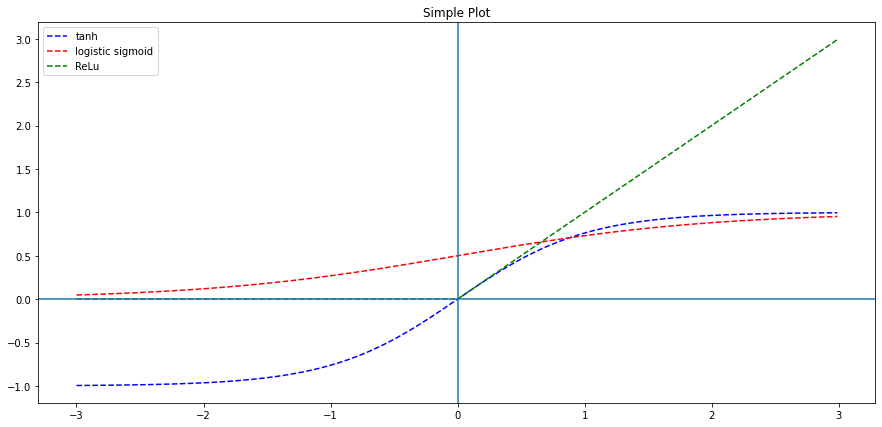

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,7))

# evenly sampled time at 200ms intervals
t = np.arange(-3., 3., 0.01)

# red dashes, blue squares and green triangles
plt.plot(t, tanh(t), 'b--', label='tanh')
plt.plot(t, logistic(t), 'r--', label='logistic sigmoid')
plt.plot(t, relu(t), 'g--', label='ReLu')


plt.title("Simple Plot")

plt.axvline(0)
plt.axhline(0)

plt.legend()
plt.show()

## Generate a Simple Training Set



Let us define our simple dataset, composed by four different images of zeros and ones (black and white pixels). For technical reasons, we do not choose exactly zero as the black value but a small number called `zz`. 

In [ ]:
zz = 0.001 #0.01
np.random.seed(172) 


# Input Images
x1 = np.array([[zz,zz,zz],[zz,zz,zz],[zz,zz,zz]])
x2 = np.array([[zz,zz,zz],[1,1,1],[zz,zz,zz]])
x3 = np.array([[1,1,1],[zz,zz,zz],[1,1,1]])
x4 = np.array([[1,1,1],[1,1,1],[1,1,1]])

# dataset
dataset = [x1,x2,x3,x4]

# labels
Y = np.array([[0.53],[0.77],[0.88],[1.0]])

# Convolutional kernel weights
W = np.random.randn(2,2) #* 4
#W = np.array([[1,2],[3,4]])
# Dense layer weights
V = np.random.randn(4,1) #* 4
#V = np.array([[1],[2],[3],[4]])

## Mathematical Derivation of Backpropagation

In machine learning, backpropagation is a widely used algorithm in training feedforward neural networks for supervised learning. The backpropagation algorithm works by computing the gradient of the loss function with respect to each weight by the chain rule, computing the gradient one layer at a time, iterating backward from the last layer. When gradients are computed, weights can be updated.

#### **Math Description of our CNN**

Let us dive a bit into the mathematics of CNN, whose structure will be composed by

* a convolutional layer with kernel size 2, stride 1;
* a scaled version sigmoid function, $\tanh(x)$;
* a fully connected layer with a logistic activation function: $f(x) = \frac{1}{1+\exp{(-x)}}$.

If $X$ is the $3\times3 $ matrix with entries $x_{ij}$ and $W_1$ the convolutional $2 \times 2$ filter with entries $w_{ij}$, the result of their convolution, named $\text{conv}(X,W_1)$, is

\\

$$\begin{bmatrix} x_{11} & x_{12} & x_{13} \\  x_{21} & x_{22} & x_{23} \\ x_{31} & x_{32} & x_{33} \end{bmatrix} 
\, * \, \begin{bmatrix} w_{11} & w_{12} \\ w_{21} & w_{22}  \end{bmatrix} 
\,=\,  \begin{bmatrix} L_{11} & L_{12} \\ L_{21} & L_{22} \end{bmatrix},$$

\\

which is a $(2,2)$ tensor, i.e a matrix. Just to remind, $L_{11}=x_{11}w_{11}+x_{12}w_{12}+x_{21}w_{21}+x_{22}w_{22}$. It is convinient to reshape the result into a $(1,4)$ tensor

\\

$$ L_1 = [L_{11}, L_{12}, L_{21}, L_{22}]$$

\\

Now we apply the scaled sigmoid activation function $L_1^A =\tanh(L_1)$, obtaining the output of the first layer $L_1^A$. The second layer is a fully connected (or dense) layer, which output is $L_2^A = \sigma(L_2)$, being $L_2 = L_1^A \cdot V$. The vector $V$ contains the weights of the second layer and $\sigma(\cdot)$ is the logistic activation function. $L_2$ is a scalar, being the output of a scalar product of two vectors.
Summarizing the structure of our simple CNN, we have

\\

* $L_1 = \text{conv} (X, W)$, first layer (convolutional), shape (1,4)

* $L_1^A =\tanh(L_1)$, first layer activation (sigmoid), shape (1,4)

* $L_2 = L_1^A \cdot V$, second layer (dense), scalar

* $L_2^A = \sigma(L_2)$, second layer activation (logistic), scalar

### Gradient Computation: Backpropagation

The loss function of our model will be the mean square error, that in the case when the `batch_size = 1` is
$$C(w) = (L_2^A - Y)^2$$

Now we will compute its derivative with respect to the model weights.

#### **Derivatives with respect to the second layer**

Let us start to compute the gradient of the cost function $C(w)$ with respect to $V$, the second layer weights:

\\

$$\frac{d C}{d V} = \frac{d C}{d L_2^A} \, \frac{d L_2^A}{d L_2} \, \frac{d L_2}{d V} = 2 (L_2^A - Y) \, [ \sigma(L_2) (1- \sigma(L_2))] \, L_1^A \,,$$

\\

where to be as clear as possible with the code we define

\\

* $\text{dC_dL2A} = 2 (L_2^A - Y) $
*  $\text{dL2A_dL2} = [ \sigma(L_2) (1- \sigma(L_2))]$
* $\text{dL2_dV}=  L_1^A $


```
dC_dL2A = 2.0*(layer_2_act - Y[2]) # scalar 
dL2A_dL2 = d_logistic(layer_2) # scalar
dL2_dV = layer_1_act_vec # (1, 4)
Grad_V =  dC_dL2A * dL2A_dL2 * dL2_dV  # (1,4)

V = V - Grad_V.T * learning_rate
```

#### **Derivatives with respect to the first layer**

Let us now compute the gradient of the cost function $C(w)$ with respect to $W_1$, the first layer weights. We explicitly compute the derivative of $C$ with respect to $w_{11}$ :

\\

$$\frac{d C}{d w_{11}} = \frac{d C}{d L_2^A} \, \frac{d L_2^A}{d L_2} \, \frac{d L_2}{d L_1^A} \, \frac{d L_1^A}{d L_1} \, \frac{d L_1}{d w_{11}} = 2(L_2^A - Y) \, [ \sigma(L_2) (1- \sigma(L_2))] \, V \, (1-\tanh (L_1)^2) \, \frac{d L_1}{d w_{11}}.$$

\\

Defing $g = 2 (L_2^A - Y) \, [ \sigma(L_2) (1- \sigma(L_2))]$ and reminding that $L_1$ is a vector

\\

$$ \frac{d C}{d w_{11}} =  g \,  V \,\left[ (1-\tanh (L_{11})^2), (1-\tanh (L_{12})^2), (1-\tanh (L_{21})^2),g(1-\tanh (L_{22})^2) \right]\, \left[ \frac{d L_{11}}{d w_{11}}, \frac{d L_{12}}{d w_{11}}, \frac{d L_{11}}{d w_{21}} , \frac{d L_{22}}{d w_{11}}\right]\,, $$  

\\

where  being that  $\left[ \frac{d L_{11}}{d w_{11}}, \frac{d L_{12}}{d w_{11}}, \frac{d L_{11}}{d w_{21}} , \frac{d L_{22}}{d w_{11}}\right] = [x_{11}, x_{12}, x_{21}, x_{22}]$ 

\\

$$ \frac{d C}{d w_{11}} = g \,  V \, \left[ (1-\tanh (L_{11})^2), (1-\tanh (L_{12})^2), (1-\tanh (L_{21})^2), (1-\tanh (L_{22})^2) \right] \, [ x_{11}, x_{12}, x_{21}, x_{22}] $$  

\\

The same procedure can be applied to the derivatives with respect to the other weights. Then, one can easily realize that the gradient of $C$ with respect to weights of the first layer is nothing else than a convolution between the image $X$ and $g (1-\tanh (L_1)^2)$

\\

$$ \begin{bmatrix} \frac{d C}{d w_{11}} & \frac{d C}{d w_{12}}  \\ \frac{d C}{d w_{21}} & \frac{d C}{d w_{22}}  \end{bmatrix} 
\,=\,  \begin{bmatrix} x_{11} & x_{12} & x_{13} \\  x_{21} & x_{22} & x_{23} \\ x_{31} & x_{32} & x_{33} \end{bmatrix} 
\, * \, \begin{bmatrix} g (1-\tanh (L_{11})^2) & g (1-\tanh (L_{12})^2) \\ g (1-\tanh (L_{21})^2)  & g (1-\tanh (L_{22})^2)   \end{bmatrix}  $$


In our code, these quantities will be defined as

```
g = 2*(dC_dL2A * dL2A_dL2).dot(V.T) #(1,1).dot((1,4)) = (1,4)
dL1A_dL1 = d_tanh(layer_1) # (2,2)
dL1_dW = dataset[2]  # (3,3)
```

As last step, it is useful to reshape from (1,4) to (2,2) the vector `g` 

```
g_reshape = np.reshape(g,(2,2)) # (2,2)
dL1A_dL1 = d_tanh(layer_1) # (2,2)

dL1_dW = dataset[2] # (3,3)
Grad_W = convolution2d(dL1_dW, g_reshape * dL1A_dL1) # (2,2)
```

## Model Definition and Training

A typical training procedure for a neural network is as follows:

- Define the neural network that has some learnable parameters, called wieghts;
- iterate over a dataset of inputs;
- process input through the network (forward pass);
- compute the loss (how far is the output from being correct);
- propagate gradients back into the network’s parameters (backward pass);
- update the weights of the network, typically using a simple update rule:
  ``weight = weight - learning_rate * gradient``.

In [ ]:
ACT = 'tanh' 

def model(image_id):
    # first layer (conv layer)
    layer_1 = convolution2d(dataset[image_id], W)
    # activation function
    layer_1_act = tanh(layer_1) if ACT == 'tanh' else relu(layer_1) # shape (2,2)
    # reshape first layer output
    layer_1_act_vec = np.expand_dims(np.reshape(layer_1_act,-1),axis=0) # shape (1,4)

    # second layer (dense layer)
    layer_2 = layer_1_act_vec.dot(V) # (1,4) dot (4,1) -> scalar
    # activation function
    layer_2_act = logistic(layer_2)
    return layer_2_act

# compute model output on image 0 before training
init_model_pred_numpy = model(0)

In [ ]:
init_model_pred_numpy 

array([[0.49876831]])

In [ ]:
# Settings
num_epoch = 100
learning_rate = 0.5

# Choose activation function
ACT = 'tanh'

cost_before_train, cost_after_train = 0, 0

final_out, start_out = np.array([[]]),np.array([[]])

# Cost before training
for i in range(len(dataset)):
    
    model_pred = model(i)
    
    # loss function
    cost = pow((model_pred - Y[i]),2).sum() * 0.25
    cost_before_train = cost_before_train + cost
    start_out = np.append(start_out, model_pred)


# ----- TRAINING -------
for iter in range(num_epoch):

    for i in range(len(dataset)):

        # ---------- Neural Network ---------------
        # first layer
        layer_1 = convolution2d(dataset[i],W)
        # activation function
        layer_1_act = tanh(layer_1) if ACT == 'tanh' else relu(layer_1) # shape (2,2)
        # reshape first layer output
        layer_1_act_vec = np.expand_dims(np.reshape(layer_1_act,-1), axis=0) # shape (1,4)

        # second layer
        layer_2 = layer_1_act_vec.dot(V) # (1,4) dot (4,1) -> scalar
        # activation function
        model_pred = logistic(layer_2)
        # -----------------------------------------

        # cost function
        cost = pow((model_pred - Y[i]),2).sum() 


        # ---------- Backpropagation ---------------
        dC_dL2A = 2*(model_pred - Y[i]) # scalar # model_pred = layer_2_act
        dL2A_dL2 = d_logistic(layer_2) # scalar
        dL2_dV = layer_1_act_vec # (1, 4)
        Grad_V =  dC_dL2A * dL2A_dL2 * dL2_dV  

        g = (dC_dL2A * dL2A_dL2).dot(V.T) #(1,1).dot((1,4)) = (1,4)
        
        
        dL1A_dL1 = d_tanh(layer_1) if ACT == 'tanh' else d_relu(layer_1) # shape (2,2)
        
        dL1_dW = dataset[i]

        g_reshape = np.reshape(g,(2,2))
        dL1A_dL1 = d_tanh(layer_1) # (2,2)
        dL1_dW = dataset[i]
        Grad_W = convolution2d(dL1_dW, g_reshape * dL1A_dL1)

        # ---------- Weights Update ---------------
        W = W - Grad_W * learning_rate
        V = V - Grad_V.T * learning_rate


# ---- Cost after training ------
for i in range(len(dataset)):

    model_pred = model(i)

    cost = pow((model_pred - Y[i]),2).sum() * 0.25
    cost_after_train = cost_after_train + cost
    final_out = np.append(final_out,model_pred)


# ----- Print Results ---
print("\nW :",W, "\n\nV :", V)
print("----------------")
print("Cost before Training: ",cost_before_train)
print("Cost after Training: ",cost_after_train)
print("----------------")
print("Start Output : ", start_out)
print("Final Output : ", final_out)
print("Ground Truth  : ", Y.T)
print("Diff  : ", final_out - Y.T)

W_numpy, V_numpy = W, V


W : [[ 0.18719648 -2.1564865 ]
 [ 0.40404502 -0.25352101]] 

V : [[-1.12665231]
 [-1.20578496]
 [-0.13551446]
 [-1.48128048]]
----------------
Cost before Training:  0.45964206899148174
Cost after Training:  0.00033220053076344974
----------------
Start Output :  [0.49876831 0.13724093 0.17536692 0.03010256]
Final Output :  [0.50179567 0.77048201 0.88130672 0.97694836]
Ground Truth  :  [[0.53 0.77 0.88 1.  ]]
Diff  :  [[-0.02820433  0.00048201  0.00130672 -0.02305164]]


That is super! We have just built from scratch a simple but complete convolutional neural network using only numpy and basic python functions. Our next step will be to code the same minimal neural network but exploiting PyTorch.  

## PyTorch Warmup

PyTorch is amongst the most widely used libraries for performing machine learning research and numerical computations. PyTorch is similar to NumPy, with the additional benefit that PyTorch allows you to perform your computations on CPUs and GPUs without any change to your code. PyTorch also makes it easy to distribute your computation across multiple devices or machines. One of the most important features of PyTorch is automatic differentiation. It allows computing the gradients of your functions analytically in an efficient manner which is crucial for training machine learning models using gradient descent method. 

So, we will now see these PyTorch useful classes (from PyTorch Tutorials):

  -  ``torch.Tensor`` - A *multi-dimensional array* with support for autograd
     operations like ``backward()``. Also *holds the gradient* w.r.t. the
     tensor.
  -  ``nn.Module`` - Neural network module. *Convenient way of
     encapsulating parameters*, with helpers for moving them to GPU,
     exporting, loading, etc.
  -  ``nn.Parameter`` - A kind of Tensor, that is *automatically
     registered as a parameter when assigned as an attribute to a*
     ``Module``.
  -  ``autograd.Function`` - Implements *forward and backward definitions
     of an autograd operation*. Every ``Tensor`` operation creates at
     least a single ``Function`` node that connects to functions that
     created a ``Tensor`` and *encodes its history*.

### Tensors Basis

Tensors are simply multidimensional arrays

* A scalar (a number) is a $0-dim$ array;
* a vector is a $1-dim$ array;
* a matrix is a $2-dim$ array;
* ...

In [ ]:
import torch

In [ ]:
s = torch.tensor(1)
v = torch.tensor([1,2,3])
m = torch.tensor([[1,2], [3,4]])
t = torch.tensor([[[1,2,3], [4,5,6]], [[7,8,9], [10,11,12]]])

print(s)
print(v)
print(m)
print(t)

tensor(1)
tensor([1, 2, 3])
tensor([[1, 2],
        [3, 4]])
tensor([[[ 1,  2,  3],
         [ 4,  5,  6]],

        [[ 7,  8,  9],
         [10, 11, 12]]])


We can extract the size of the tensor by simply

In [ ]:
s.size(), v.size(), m.size(), t.size()

(torch.Size([]), torch.Size([3]), torch.Size([2, 2]), torch.Size([2, 2, 3]))

We can also generate a random vector of arbitrary size

In [ ]:
d = torch.rand([2, 2, 2])
d

tensor([[[0.4235, 0.6670],
         [0.2222, 0.3949]],

        [[0.5163, 0.9313],
         [0.9348, 0.7980]]])

When you have more than one tensor you can perform algebric operations (and then convert it to a numpy array)

In [ ]:
x = torch.randn([3, 5])  # random normal
y = torch.randn([5, 4])
z = x @ y # matrix multiplication

print(z.numpy())

[[-2.2723956   0.05799705 -0.8286556   0.2691786 ]
 [-2.0337021   1.7422463  -0.15035552 -1.9155627 ]
 [-0.33266476 -0.13925168  0.16327095  1.4322754 ]]


In [ ]:
z.size()

torch.Size([3, 4])

### Automatic Differentiation

One of the advantage of PyTorch over NumPy is its automatic differentiation which is very useful in optimization applications, such as neural network backpropagation. 

#### Example 1 (simple)

Suppose to have a composite function which is a chain of two functions: g(u(x)). To compute the derivative of g with respect to x we can use the chain rule: 

$$\frac{dg}{dx} = \frac{dg}{du} \cdot \frac{du}{dx}$$

PyTorch can analytically compute the derivatives for us.

To compute the derivatives in PyTorch first we create a tensor and set its `requires_grad = true`. We can use tensor operations to define our functions. Let us give the following example

In [ ]:
x = torch.tensor(0.5, requires_grad=True)

def u(x):
  return x * x

def g(u):
  return -2*u

Our composite function is $g(x) = -2 x^2$, whose derivative is $dg/dx = - 4 x$. At the point $x = 0.5$ its value is $-2$. Let us check this result

In [ ]:
dg_dx = torch.autograd.grad(g(u(x)), x)[0]
print(dg_dx) 

tensor(-2.)


#### Example 2

Assume that we have samples from a curve (say $f(x) = 3x^2 + 5$) and we want to estimate f(x) based on these samples. We define a parametric function $g(x, w) = w_0 x^2 + w_1 x + w_2$, which is a function of the input x and parameters w. The goal is then to find the parameters such that $g(x, w) ≈ f(x)$. 


In [ ]:
# Assuming we know that the desired function is a polynomial of 2nd degree, we
# allocate a vector of size 3 to hold the coefficients and initialize it with
# random noise.
w = torch.tensor(torch.randn([3, 1]), requires_grad=True)

# We use the Adam optimizer with learning rate set to 0.1 to minimize the loss.
opt = torch.optim.Adam([w], 0.1)

def model(x):
  f = torch.stack([x*x, x , torch.ones_like(x)], 1)
  pred = torch.squeeze(f @ w, 1)
  return pred

def compute_loss(y, pred):
    # The loss is defined to be the mean squared error distance between our
    # estimate of y and its true value. 
    loss = torch.nn.functional.mse_loss(y, pred)
    return loss

def data_generator():
  # Generate some training data (between -10 and 10) based on the true function
  x = torch.rand(100) * 20 - 10
  y = 3*x*x + 5  
  return x, y

def train_step():
  x, y = data_generator()

  pred = model(x)

  loss = compute_loss(y, pred)

  opt.zero_grad()
  loss.backward()
  opt.step()

for _ in range(1000):
    train_step()

print(w.detach().numpy())


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.


[[ 3.002180e+00]
 [-6.964267e-04]
 [ 4.872326e+00]]


## PyTorch CNN Implementation I (Custom Version)

The main goal of this section is to warm up with PyTorch and more in general the standard pipeline to build a model and its training. We will code exactly the same problem we just solved above but in a PyTorch fashioned way.

To find the same results, first we must initialize the weights with the same values.

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch

#### Convolutions Comparison: our `convolution2d()` vs `F.conv2d()`

Let us check that our 2d-convolution written above in numpy will give us the same results of the built-in PyTorch 2d-convolution `F.conv2d()`. We will not use immediatly `F.conv2d()`, but later on. However, now it is the right time to check it gives the same output of our `convolution2d()`

In [ ]:
# Select the same seed
np.random.seed(172)
#torch.manual_seed(172)

# Convolutional kernel weights
W = np.random.randn(2,2) #random normal
# Dense layer weights
V = np.random.randn(4,1)

# Convolution
conv_numpy = convolution2d(dataset[2], W)

Now let us compute the PyTorch implementation of the 2d-convolution operation. It is important to

* Transform numpy tensors in **torch.tensors**;
* set the correct shape (view in PyTorch) for our tensors.

In [ ]:
dtype = torch.float
device = torch.device("cpu")

# we must transform all numpy tensors in pytorch tensors
dataset = torch.tensor(dataset, device=device, dtype=dtype)
Y = torch.tensor(Y, device=device, dtype=dtype)
W = torch.tensor(W, device=device, dtype=dtype, requires_grad=True)
V = torch.tensor(V, device=device, dtype=dtype, requires_grad=True)

# we must reshape tensors according to
# image input must be of shape (batch, in_channel, h, w)
# kernel must be of shape (out_channel, in_channel, h, w)
image = dataset[2].view(1, 1, 3, 3)
W = W.view(1,1,2,2)

# Convolution
conv_pytorch = F.conv2d(image, W)

Let us compute their differece and see that it is close to zero

In [ ]:
diff = conv_numpy - conv_pytorch.detach().numpy()

assert all(v <= 1e-5 for v in diff.flatten())

**About detach...**

In order to enable automatic differentiation, PyTorch keeps track of all operations involving tensors for which the gradient may need to be computed (i.e., `require_grad = True`). The operations are recorded as a directed graph. The detach() method constructs a new view on a tensor which is declared not to need gradients, i.e., it is to be excluded from further tracking of operations, and therefore the subgraph involving this view is not recorded.

#### Custom PyTorch Layers: Convolutional and Linear Layer

Now we will build our custom convolutional layer. We want to be sure to reproduce the same results of the previous numpy approach. For this reason we set the same seed. Since numpy and PyTorch have different random generators, we will

* use numpy.random function to generate the initial weights;
* we will convert them in torch.tensors with **torch.from_numpy**.

In [ ]:
np.random.seed(172)
torch.manual_seed(172)

# Convolutional kernel weights
kernel_h, kernel_w = 2, 2
W = np.random.randn(kernel_h, kernel_w)
# Dense layer weights
size_in, size_out = 4, 1
V = np.random.randn(4,1)

class MyConv2dLayer(nn.Module):
    """ Custom Conv layer"""
    def __init__(self, kernel_h = 2, kernel_w = 2):
        super().__init__()

        self.kernel_h, self.kernel_w = kernel_h, kernel_w

        # to keep control of the seed, import weight from numpy
        self.W  = nn.Parameter(torch.from_numpy(W).float(), requires_grad=True)

        # otherwise this is the correct weights init
        #weights = torch.tensor(self.kernel_h, self.kernel_w)
        #self.W = nn.Parameter(weights, requires_grad=True)
        #torch.nn.init.normal_(self.W, mean=0.0, std=1.0)

    def forward(self, x):
        W = self.W.view(1, 1, self.kernel_h, self.kernel_w)
        out  = F.conv2d(x, W)
        return out

conv = MyConv2dLayer(kernel_h, kernel_w)

# check that we obtain the same result
diff = conv(image) - conv_pytorch 

assert all(v <= 1e-5 for v in diff.flatten())

When you build a custom layer (or model), using `nn.Module` you can take advantage of the already present methods. Then, let us check the parameters of `MyConvLayer()`

In [ ]:
list(conv.parameters()), W

([Parameter containing:
  tensor([[ 1.1561, -1.1876],
          [ 0.9290,  0.2715]], requires_grad=True)],
 array([[ 1.15609793, -1.18758506],
        [ 0.92901938,  0.27145336]]))

Now it is the turn of the custom linear layer.



In [ ]:
class MyLinearLayer(nn.Module):
    """ Custom Linear layer"""
    def __init__(self, size_in = size_in, size_out = size_out):
        super().__init__()

        self.size_in, self.size_out = size_in, size_out

        # to keep control of the seed
        #weights = np.random.randn(self.size_in, self.size_out)
        self.V = nn.Parameter(torch.from_numpy(V).float(), requires_grad=True)
        #self.V = weights.view(self.size_in, self.size_out)

        # otherwise this is the correct weights init
        #weights = torch.Tensor(size_out, size_in)
        #self.W = nn.Parameter(weights, requires_grad=True)
        #torch.nn.init.normal_(self.W, mean=0.0, std=1.0)


    def forward(self, x):
        V = self.V.view(self.size_in, self.size_out)
        #print(x, self.V)
        out = torch.mm(x, self.V)
        return out 

linearlay = MyLinearLayer(size_in, size_out)
linearlay(conv_pytorch.view(1,4))

# Let us check that it gives the same results as the numpy linear layer built before

layer_1_act_vec = np.expand_dims(np.reshape(conv_numpy,-1),axis=0) # shape (1,4)
layer_2 = layer_1_act_vec.dot(V) 

torch.tensor(layer_2) - linearlay(conv_pytorch.view(1,4))

tensor([[-1.2410e-07]], dtype=torch.float64, grad_fn=<SubBackward0>)

In [ ]:
list(linearlay.parameters()), V

([Parameter containing:
  tensor([[-1.0981],
          [-1.1772],
          [-0.2968],
          [-1.6425]], requires_grad=True)], array([[-1.09807964],
        [-1.17721229],
        [-0.29675542],
        [-1.64252144]]))

So far we have built two custom layers. Now we will use them for our simple CNN that share the same structure of the numpy implementation

In [ ]:
class MySimpleCNN(nn.Module):
    def __init__(self):
        super(MySimpleCNN, self).__init__()
        self.conv2d = MyConv2dLayer(2,2)
        self.linear = MyLinearLayer(4, 1)

    def forward(self, x):
        #x_reshaped = x.view(1,1,3,3)
        layer1_out = torch.tanh(self.conv2d(x)) # [1, 1, 2, 2]
        layer1_out_flat = layer1_out.view(1, 4) # [1, 1, 4]
        y_pred = torch.sigmoid(self.linear(layer1_out_flat))
        return y_pred.squeeze(-1).squeeze(-1)

Let us now check (again!) that the models (numpy and pytorch) give identical outputs

In [ ]:
model = MySimpleCNN()
list(model.parameters()), W, V

# test pytorch model on image 0
init_model_pred_pytorch = model(dataset[0].view(1, 1, 3, 3))

# Diff initial model predictions (numpy vs pytorch)
init_model_pred_pytorch - torch.tensor(init_model_pred_numpy)

tensor([[-4.0474e-08]], dtype=torch.float64, grad_fn=<SubBackward0>)

When we built the numpy training we used as loss function the mean square error. Let us check that the built-in PyTorch `nn.MSELoss()` return the same value

In [ ]:
loss_fn = nn.MSELoss(reduction = 'mean')
pow((np.array([0.70]) - np.array([0.83])),2), loss_fn(torch.tensor([0.70]), torch.tensor([0.83]))


(array([0.0169]), tensor(0.0169))

Now we are ready to start the training using our customized PyTorch model

In [ ]:
# Settings
num_epoch = 100
learning_rate = 0.5

model = MySimpleCNN()


loss_fn = nn.MSELoss(reduction = 'mean')
# Use the optim package to define an Optimizer that will update the weights of
# the model for us. Here we will use Adam; the optim package contains many other
# optimization algorithms. The first argument to the Adam constructor tells the
# optimizer which Tensors it should update.
# optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


# ----- TRAINING -------
for iter in range(num_epoch):
    for i in range(len(dataset)):
      
      # set the correct shape for the image
      image = dataset[i].view(1, 1, 3, 3)

      model_pred = model(image)
      #print(model_pred , Y[i])
      
      loss = loss_fn(model_pred, Y[i])

      # Zero the gradients before running the backward pass.
      model.zero_grad()

      # Backward pass: compute gradient of the loss with respect to all the learnable
      # parameters of the model. Internally, the parameters of each Module are stored
      # in Tensors with requires_grad=True, so this call will compute gradients for
      # all learnable parameters in the model.
      loss.backward()

      # In alternative of optimizer step using torch.optim:
      # Update the weights using gradient descent (almost manually). Each parameter is a Tensor, so
      # we can access its gradients like we did before.
      # torch.no_grad(): it temporarily sets all the requires_grad flag to false. If we omit it,
      # then weight update step will be added to the computation graph of the model which is not desired.
      # This will simply update their values without changing their gradients.
      with torch.no_grad(): 
          for param in model.parameters():
              param -= learning_rate * param.grad


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:445: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Let us now check the ouput differences between numpy and PyTorch approaches

In [ ]:
list(model.parameters())

[Parameter containing:
 tensor([[ 0.1872, -2.1565],
         [ 0.4040, -0.2535]], requires_grad=True), Parameter containing:
 tensor([[-1.1267],
         [-1.2058],
         [-0.1355],
         [-1.4813]], requires_grad=True)]

In [ ]:
diff = list(model.parameters())[0].detach().numpy() - W_numpy

assert all(v <= 1e-5 for v in diff.flatten())

In [ ]:
diff = list(model.parameters())[1].detach().numpy() - V_numpy

assert all(v <= 1e-5 for v in diff.flatten())

In [ ]:
res = []

for i in range(len(dataset)):
  image = dataset[i].view(1, 1, 3, 3)
  model_pred = model(image)
  pred = model_pred.detach().numpy()
  res.append(pred)

print(res)
print(Y.squeeze(-1).numpy())

[array(0.50179565, dtype=float32), array(0.770482, dtype=float32), array(0.8813068, dtype=float32), array(0.97694844, dtype=float32)]
[0.53 0.77 0.88 1.  ]


In [ ]:
diff = list(res) - final_out  # final_out contains the predictions of the numpy model

assert all(v <= 1e-5 for v in diff)

## PyTorch CNN Implementation II

Below, we will repeat what done so far but 

* without using custom layers. We will use PyTorch built-in convolutional and linear layers: `nn.Conv2d()` and `cc.Linear()` ;

* using `torch.optim` that will take care for us of stochastic gradient descend.

Note: using `nn.Conv2d()` and `cc.Linear()`, we will not expect exact results with respect to previous cases. The reason is that, as mentioned above, built-in PyTorch functions have internal random initialization which, given a seed, is different from numpy.

In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        # PyTorch built-in conv2d and linear layers
        self.conv2d = nn.Conv2d(1, 1, (2,2)) # channel_in, channel_out, kernel_size
        self.linear = nn.Linear(4, 1)

    def forward(self, x):
        layer1_out = torch.tanh(self.conv2d(x)) # [1, 1, 2, 2]
        layer1_out_flat = layer1_out.view(1, 4) # [1, 1, 4]
        y_pred = torch.sigmoid(self.linear(layer1_out_flat))
        return y_pred.squeeze(-1).squeeze(-1)

In [ ]:
# Settings
num_epoch = 100
learning_rate = 0.05

model = SimpleCNN()


loss_fn = nn.MSELoss(reduction = 'mean')

# Use the optim package to define an Optimizer that will update the weights of
# the model for us. Here we will use Adam; the optim package contains many other
# optimization algorithms. The first argument to the Adam constructor tells the
# optimizer which Tensors it should update.
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


# ----- TRAINING -------
for iter in range(num_epoch):
    for i in range(len(dataset)):
      
      # set the correct shape for the image
      image = dataset[i].view(1, 1, 3, 3)

      model_pred = model(image)
      #print(model_pred , Y[i])
      
      loss = loss_fn(model_pred, Y[i])

      # Before the backward pass, use the optimizer object to zero all of the
      # gradients for the variables it will update (which are the learnable
      # weights of the model). This is because by default, gradients are
      # accumulated in buffers( i.e, not overwritten) whenever .backward()
      # is called. Checkout docs of torch.autograd.backward for more details.
      optimizer.zero_grad()

      # NOTE: What is the difference between model.zero_grad() and optimizer.zero_grad()?
      # The distinction is useful when you have multiple models in the same optimizer, 
      # or multiple optimizer for different part of their model. In these cases you can have 
      # more freedom and choose what to zero grad.

      # Backward pass: compute gradient of the loss with respect to model
      # parameters
      loss.backward()

      # Calling the step function on an Optimizer makes an update to its
      # parameters
      optimizer.step()

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:445: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [ ]:
res = []

for i in range(len(dataset)):
  image = dataset[i].view(1, 1, 3, 3)
  model_pred = model(image)
  pred = model_pred.detach().numpy()
  res.append(pred)

print(res)
print(Y.squeeze(-1).numpy())

[array(0.529691, dtype=float32), array(0.7699678, dtype=float32), array(0.8840444, dtype=float32), array(0.97438216, dtype=float32)]
[0.53 0.77 0.88 1.  ]


That is great! In this case the results do not match exactly because of the different weights initialization of built-in PyTorch layers parameters.